# MLADHD Experiment notebook

Notebook created by [Gonzalo Córdova](https://github.com/gonzalo-cordova-pou) in January 2023.

For any doubts: gonzalo.cordova@estudiantat.upc.edu

## Setting up our Colab enviroment

We import Python packages:

In [1]:
from os import listdir
from os.path import isfile, join
import pandas as pd
import random
import torch
import numpy as np
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import sampler, DataLoader
from torchvision.models import resnet50, ResNet50_Weights
import matplotlib.pyplot as plt

We mount our shared folder in Google Drive.

IMPORTANT: You must have a direct access to the 2023-ADHD-VCU-UPC folder in your main Google Drive root.

In [2]:
from google.colab import drive
# Make sure to include a direct access from your Drive to the project shared folder
drive.mount('/content/drive')

Mounted at /content/drive


We clone [our GitHub repo](https://github.com/JulianaGSouza/MLADHD) to the Colab enviroment. Make sure that you have access to the repository.

If you don't know how to generate a github token check this link: https://docs.github.com/en/enterprise-server@3.4/authentication/keeping-your-account-and-data-secure/creating-a-personal-access-token



In [3]:
username = 'JulianaGSouza'
repository = 'MLADHD'
token = ''

In [4]:
!git clone https://{token}@github.com/{username}/{repository}

Cloning into 'MLADHD'...
remote: Enumerating objects: 3556, done.
remote: Counting objects: 100% (540/540), done.
remote: Compressing objects: 100% (519/519), done.
remote: Total 3556 (delta 28), reused 523 (delta 20), pack-reused 3016
Receiving objects: 100% (3556/3556), 703.23 MiB | 22.08 MiB/s, done.
Resolving deltas: 100% (43/43), done.


Finally import our MLADHD module.

In [5]:
from MLADHD.mlmodeling import *

## Experiments

- [**Case 1:** Crating a new model.](#s1)
- [**Case 2:** Using our pretrained models [IN PROGRESS..]](#s2)

<a name='s1'></a>
### Experiment - Case 1: Creating a new model

The idea of case 1 is to create a model by using a pretrained PyTorch model and adding a classification layer. We will train the model freezing the pretrained model (resnet50, in this case).

- Choose a name for the model
- Indicate where the data is stored
- Choose where to save the model
- Choose a validation size

**IMPORTANT** Make sure that the model_dir exists, create the folder if necessary

In [6]:
model_name = 'test'
data_dir = './drive/MyDrive/2023-ADHD-VCU-UPC/data/'
models_dir = './drive/MyDrive/2023-ADHD-VCU-UPC/models/'
valid_size = 0.2

Create a dictionary with the hyperparameters:

In [7]:
hyperparams = {
    'lr': 0.003, 
    'epochs': 1, 
    'batch_size': 64,
    'optimizer': 'Adam',            # options: Adam, SGD
    'loss': 'NLLLoss',              # options: NLLLoss, CrossEntropyLoss
    'pretrained_model': 'resnet50', # options: resnet50, vgg16
    'freeze_pretrained_model': True,# options: True, False
    'train_transforms': 'default',  # options: default
    'test_transforms': 'default'    # options: default
}

Create a new experiment with the MLADHD Python class.

In [8]:
experiment = MLADHD(model_name, data_dir, models_dir, hyperparams)

Load and split the data into train and test.

In [9]:
experiment.load_split_dataset(valid_size)

Train size:  24
Test size:  6
Trainloader and Testloader created. Access them with self.train and self.test


Create a new model using the pretrained model indicated in the hyperparameters

In [10]:
experiment.create_model()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Check what pretrained model has been used.

In [11]:
experiment.hyperparams["pretrained_model"]

'resnet50'

Now lets train our model with the train data:

In [12]:
experiment.train_model()

Epoch: 1/1..  Training Loss: 0.010.. 
Training finished!
Model saved as:  test_resnet50_2023-01-07_16-30-08.pth


Check that the new trained model and the hyperparameters used have been stored in the indicated folder with the name *modelname_pretrainedmodel_date_time.pth* and *modelname_pretrainedmodel_date_time.json* respectively.

Now lets test our model with the test data and see the test_loss and accuracy.

In [13]:
print("Testing model...")
test_loss,accuracy = experiment.test_model()
print(test_loss,accuracy)

Testing model...
0.1275309333577752 0.9568865696589152


Plot the training loss during the last epoch.

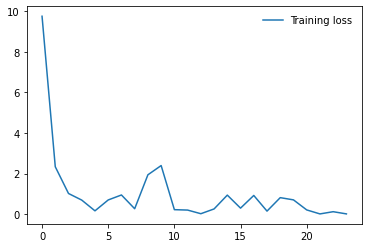

In [14]:
plt.plot(experiment.running_loss[-1],label='Training loss')
plt.legend(frameon=False)
plt.show()

<a name='s2'></a>
### Experiment - Case 2: Using our pretrained models [IN PROGRESS..]

If we have already trained a model we can load it to our enviroment in order to test it or to predict images.

We will load:
- The trained model
- The hyperparameters used for its training

In [17]:
data_dir = './drive/MyDrive/2023-ADHD-VCU-UPC/data/'
models_dir = './drive/MyDrive/2023-ADHD-VCU-UPC/models/'
pretrained_model = 'test_resnet50_2023-01-07_16-30-08'
model_name = pretrained_model.split('_')[0]
print("Loading hyperparams...")
with open(models_dir+pretrained_model+'.json', 'r') as fp:
    hyperparams = json.load(fp)
# when loading a pretrained model, the date is updated to the current date
# so that the model is not overwritten (see __init__)
experiment2 = MLADHD(model_name, data_dir, models_dir, hyperparams)

Loading hyperparams...


In [18]:
experiment2.hyperparams

{'lr': 0.003,
 'epochs': 1,
 'batch_size': 64,
 'optimizer': 'Adam',
 'loss': 'NLLLoss',
 'pretrained_model': 'resnet50',
 'freeze_pretrained_model': True,
 'train_transforms': 'default',
 'test_transforms': 'default'}